In [1]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [2]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

<span style="color:#13213b;">[Andrii Gakhov](https://www.gakhov.com) / PyCon UA 2018</span>
* * *
## An Introduction to Time Series Forecasting with Python
Time series is an important instrument to model, analyze and predict data collected over time. In this talk, we learn the basic theoretical concepts without going deep into mathematical aspects, study different models, and try them in practice using StatsModels, Prophet, scikit-learn, and keras.

# Part 2. Facebook Prophet Model
******

### OS visits to UK (All visits) 
The dataset represents the monthly total number of visits to the UK by overseas residents (in thousands)<br>from January 1980 to October 2017. 

#### Source: [Office for National Statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/timeseries/gmaa/ott)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Load the data into Pandas DataFrame

In [5]:
import pandas as pd
df = pd.read_csv("data/GMAA-040218.csv", header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value = df.value.astype(int)

In [6]:
import numpy as np

train_range = df[df.period < '2015-01-01'].index
test_range = df[(df.period >= '2015-01-01')].index

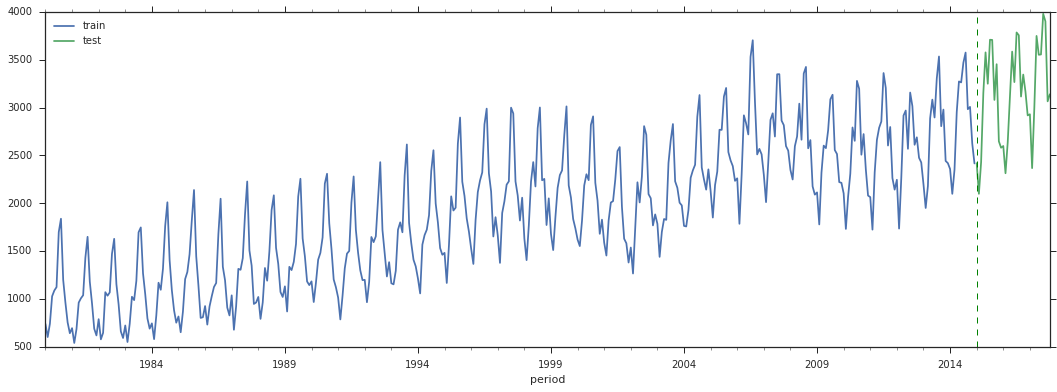

In [7]:
fig, ax = plt.subplots(figsize=(18,6))
df.loc[train_range].plot(x="period", y="value", ax=ax, label="train")
df.loc[test_range].plot(x="period", y="value", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('images/prophet-split.png');

# Facebook Prophet Model

Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.

#### $$X(t) = T(t) + S(t) + H(t) + \varepsilon_t$$

##### <small>$T(t)$ - trend, $S(t)$ - seasonal effects, $H(t)$  - holidays (potentially irregular), $\varepsilon_t$ - unpredicted effects.</small>

#### The seasonality is modeled by the Fourier Series.

### Specifying Seasonalities
Prophet by default can fit weekly and yearly seasonalities, if the time series is more than two cycles long. However, it's possiblIt to add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method.

### Holidays and Special Events
Prophet allows to include holidays and other special events. It must include all occurrences of the holiday, both in the past and in the future (out as far as the forecast is being made). If they won't repeat in the future, Prophet will model them and then not include them in the forecast.

In [8]:
from fbprophet import Prophet

https://en.wikipedia.org/wiki/Tourism_in_the_United_Kingdom

Top 3 countiries visiting UK: FR, US, DE

In [9]:
import holidays

years = range(1980, 2017)

uk_holidays = holidays.UK(years=years)

visitors_holidays = holidays.FRA(years=years) +\
    holidays.US(years=years) +\
    holidays.DE(years=years)

all_holidays = uk_holidays + visitors_holidays

In [10]:
df_holidays = pd.DataFrame.from_dict(all_holidays, orient="index").reset_index()
df_holidays.columns = ["ds", "holiday"]

In [11]:
from datetime import date

changepoints = {
    date(2001,9,11): "September 11 attacks in the US",
    date(2008,9,15): "Start of the Global Financial Crisis",
    date(2009,8,1): "End of the Global Financial Crisis"
}

In [12]:
df_prophet_train = df.loc[train_range][["period", "value"]]
df_prophet_train.columns = ["ds", "y"]

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoints=list(changepoints.keys()),
    holidays=df_holidays,
    mcmc_samples=12,
    growth='linear',
    interval_width=0.9)

In [13]:
model.fit(df_prophet_train);

## Make prediction

In [14]:
df_prophet_test = df.loc[test_range][["period", "value"]]
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = df.loc[test_range].value.values

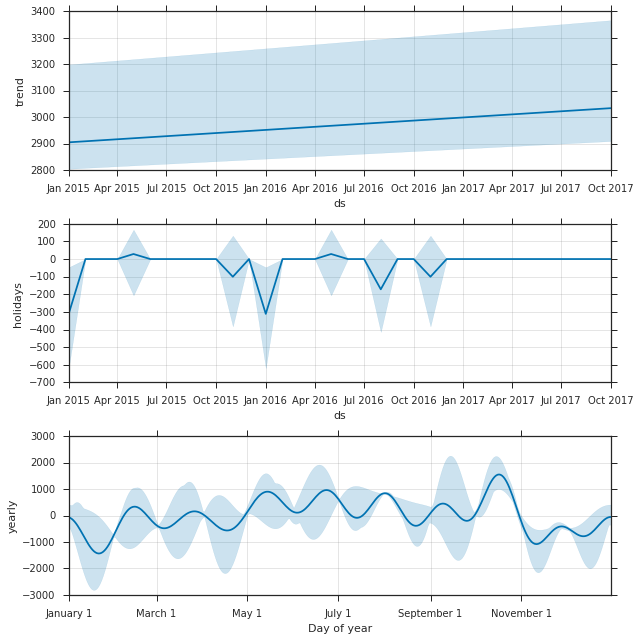

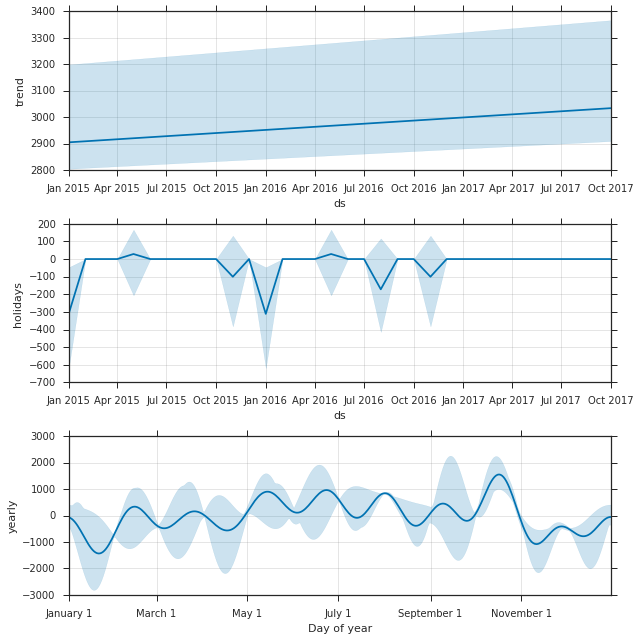

In [15]:
model.plot_components(forecast)

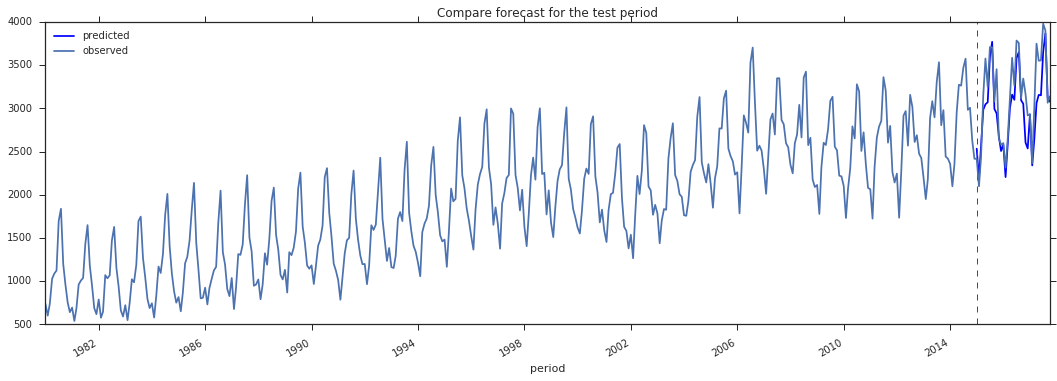

In [16]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.savefig('images/prophet-forecast-testrange.png')
plt.show();

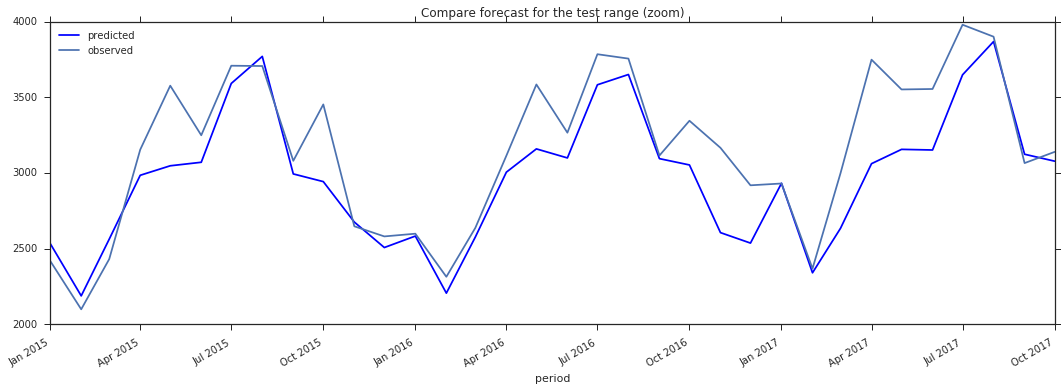

In [17]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')


plt.savefig('images/prophet-forecast-testrange-zoom.png')
plt.show();

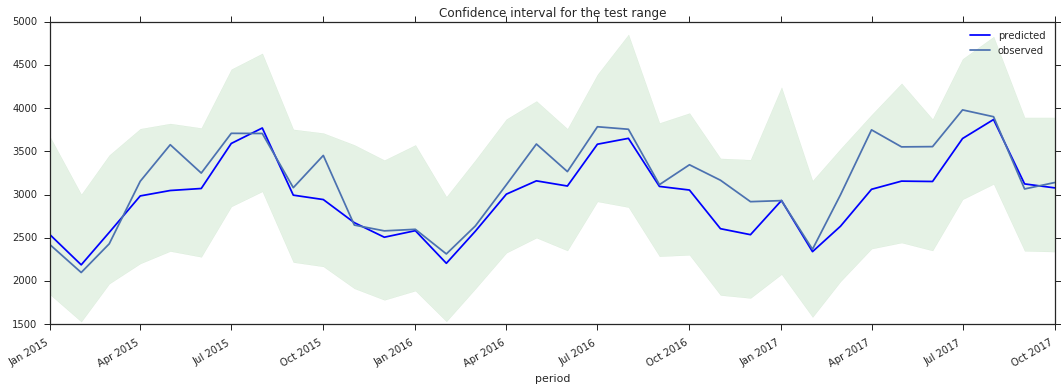

In [18]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    forecast_ci['yhat_lower'],
    forecast_ci['yhat_upper'],
    color='g',
    alpha=0.1)

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

plt.savefig('images/prophet-forecast-testrange-confidence-interval.png')
plt.show();

### Evaluate the forecast

In [19]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

In [20]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

MAE (test): 203
MSE (test): 75054
R2  (test): 0.704
U   (test): 0.000029
